In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchinfo import summary
from comet_ml import Experiment

# Local imports
sys.path.append("/Users/leo/Desktop/Thesis/utils/")
sys.path.append("/Users/leo/Desktop/Thesis/models/")

from helper_functions import (delete_ds_store,plot_metrics,test,train,mean_std_finder,load_model)
from MBNV3_v2 import MBNV3_Creator
from config import comet_token, project_name, workspace
from torchvision.models import (mobilenet_v3_small, MobileNet_V3_Small_Weights as weights_small)

# Setting the seed for reproducibility
torch.manual_seed(42)

In [2]:
prms = {
    "backbone": mobilenet_v3_small,
    "weights": None,
    "module": None,
    "module_alias": "SE",
    "data_path": "/Users/leo/Desktop/Thesis/data/vgg_100/",
    "batch_size": 32,
    "img_size": 224,
    "num_classes": 100,
    "epochs": 50,
    "learning_rate": 0.001,
    "device": "mps",
    "model": None,
    "experiment": Experiment(api_key=comet_token, project_name=project_name, workspace=workspace, log_code=True),
    "load_model": False,
}
prms["model_save_path"] = f"./saved_weights/{prms['module_alias']}_{prms['data_path'].split('/')[-2]}.pth"

model = prms["model"] = MBNV3_Creator(prms["num_classes"], prms["device"])
delete_ds_store(prms["data_path"])

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/leothesouthafrican/mbnv3-vgg-100/6a518f69e0e84898a98afac7c470314f



In [3]:
#mean, std = mean_std_finder(prms["data_path"])
mean, std = torch.tensor([0.5235, 0.4358, 0.3905]), torch.tensor([0.2993, 0.2770, 0.2729])

train_transform = transforms.Compose([
    transforms.Resize((prms["img_size"], prms["img_size"])),
    transforms.RandAugment(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.Resize((prms["img_size"], prms["img_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [4]:
#Accessing the data
train_data = torchvision.datasets.ImageFolder(prms["data_path"] + "train/", transform=train_transform)
val_data = torchvision.datasets.ImageFolder(prms["data_path"] + "val/", transform=test_transform)
test_data = torchvision.datasets.ImageFolder(prms["data_path"] + "test/", transform=test_transform)

#Creating the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=prms["batch_size"], shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=prms["batch_size"], shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=prms["batch_size"], shuffle=False, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


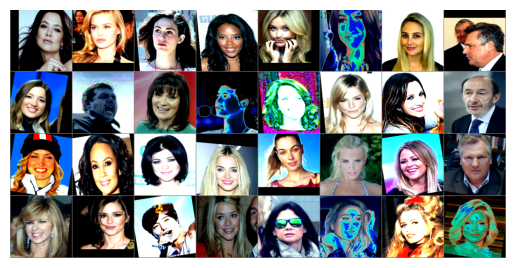

In [5]:
#display random images from the dataset
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #drop axis labels
    plt.axis('off')
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [6]:
#build the model
model = load_model(model.build_model(), prms["model_save_path"]) if prms["load_model"] else model.build_model()

# Loss and optimizer
criterion = nn.CrossEntropyLoss().to(prms["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=prms["learning_rate"])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

prms["experiment"].log_parameters({"loss": criterion, "optimizer": optimizer}) if prms["experiment"] else None

SE block in layers: [1, 4, 5, 6, 7, 8, 9, 10, 11].
Model weights initialized with Xavier initialization.


In [7]:
model_summary = summary(model, input_size=(1, 3, prms["img_size"], prms["img_size"]),
        col_names = ["input_size", "output_size", "num_params", "kernel_size", "mult_adds", "trainable"],
        col_width = 20,
        row_settings = ["var_names"],
        depth=8)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
prms["experiment"].log_metric("total_params", total_params) if prms["experiment"] else None

model_summary

/Users/leo/Desktop/Thesis/thesis_env/lib/python3.11/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Kernel Shape         Mult-Adds            Trainable
MobileNetV3 (MobileNetV3)                                    [1, 3, 224, 224]     [1, 100]             --                   --                   --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 576, 7, 7]       --                   --                   --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 16, 112, 112]    --                   --                   --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 16, 112, 112]    432                  [3, 3]               5,419,008            True
│    │    └─BatchNorm2d (1)                                  [1, 16, 112, 112]    [1, 16, 112, 112]    32                   --              

100%|██████████| 179/179 [00:22<00:00,  7.84it/s]


Epoch: 01 | Epoch Time: 6.0m 4s
	Train Loss: 3.980 | Train Acc: 6.51%
	 Val. Loss: 3.489 |  Val. Acc: 13.12%
Best Accuracy Achieved: 13.12% on epoch 01


100%|██████████| 179/179 [00:19<00:00,  9.04it/s]


Epoch: 02 | Epoch Time: 6.0m 57s
	Train Loss: 3.250 | Train Acc: 17.30%
	 Val. Loss: 2.869 |  Val. Acc: 24.81%
Best Accuracy Achieved: 24.81% on epoch 02


100%|██████████| 179/179 [00:16<00:00, 10.87it/s]


Epoch: 03 | Epoch Time: 5.0m 36s
	Train Loss: 2.714 | Train Acc: 28.63%
	 Val. Loss: 2.335 |  Val. Acc: 37.88%
Best Accuracy Achieved: 37.88% on epoch 03


100%|██████████| 179/179 [00:17<00:00, 10.38it/s]


Epoch: 04 | Epoch Time: 5.0m 23s
	Train Loss: 2.307 | Train Acc: 38.25%
	 Val. Loss: 1.966 |  Val. Acc: 46.23%
Best Accuracy Achieved: 46.23% on epoch 04


100%|██████████| 179/179 [00:18<00:00,  9.61it/s]


Epoch: 05 | Epoch Time: 5.0m 24s
	Train Loss: 1.996 | Train Acc: 45.91%
	 Val. Loss: 1.774 |  Val. Acc: 51.14%
Best Accuracy Achieved: 51.14% on epoch 05


100%|██████████| 179/179 [00:18<00:00,  9.69it/s]


Epoch: 06 | Epoch Time: 5.0m 26s
	Train Loss: 1.767 | Train Acc: 51.54%
	 Val. Loss: 1.527 |  Val. Acc: 57.51%
Best Accuracy Achieved: 57.51% on epoch 06


100%|██████████| 179/179 [00:21<00:00,  8.37it/s]


Epoch: 07 | Epoch Time: 5.0m 31s
	Train Loss: 1.609 | Train Acc: 55.70%
	 Val. Loss: 1.557 |  Val. Acc: 57.25%


100%|██████████| 179/179 [00:19<00:00,  9.29it/s]


Epoch: 08 | Epoch Time: 5.0m 40s
	Train Loss: 1.467 | Train Acc: 59.45%
	 Val. Loss: 1.359 |  Val. Acc: 62.49%
Best Accuracy Achieved: 62.49% on epoch 08


100%|██████████| 179/179 [00:18<00:00,  9.58it/s]


Epoch: 09 | Epoch Time: 5.0m 40s
	Train Loss: 1.355 | Train Acc: 62.16%
	 Val. Loss: 1.292 |  Val. Acc: 64.38%
Best Accuracy Achieved: 64.38% on epoch 09


100%|██████████| 179/179 [00:18<00:00,  9.57it/s]


Epoch: 10 | Epoch Time: 5.0m 30s
	Train Loss: 1.255 | Train Acc: 64.85%
	 Val. Loss: 1.169 |  Val. Acc: 67.82%
Best Accuracy Achieved: 67.82% on epoch 10


100%|██████████| 179/179 [00:17<00:00, 10.28it/s]


Epoch: 11 | Epoch Time: 5.0m 34s
	Train Loss: 1.168 | Train Acc: 66.99%
	 Val. Loss: 1.134 |  Val. Acc: 68.45%
Best Accuracy Achieved: 68.45% on epoch 11


100%|██████████| 179/179 [00:19<00:00,  9.15it/s]


Epoch: 12 | Epoch Time: 5.0m 37s
	Train Loss: 1.100 | Train Acc: 68.55%
	 Val. Loss: 1.042 |  Val. Acc: 71.40%
Best Accuracy Achieved: 71.40% on epoch 12


100%|██████████| 179/179 [00:18<00:00,  9.62it/s]


Epoch: 13 | Epoch Time: 5.0m 33s
	Train Loss: 1.034 | Train Acc: 70.55%
	 Val. Loss: 1.116 |  Val. Acc: 69.03%


100%|██████████| 179/179 [00:20<00:00,  8.81it/s]


Epoch: 14 | Epoch Time: 5.0m 48s
	Train Loss: 0.977 | Train Acc: 72.00%
	 Val. Loss: 1.007 |  Val. Acc: 72.06%
Best Accuracy Achieved: 72.06% on epoch 14


100%|██████████| 179/179 [00:22<00:00,  7.87it/s]


Epoch: 15 | Epoch Time: 5.0m 43s
	Train Loss: 0.937 | Train Acc: 72.84%
	 Val. Loss: 1.098 |  Val. Acc: 69.99%


100%|██████████| 179/179 [00:18<00:00,  9.71it/s]


Epoch: 16 | Epoch Time: 5.0m 44s
	Train Loss: 0.883 | Train Acc: 74.70%
	 Val. Loss: 0.984 |  Val. Acc: 73.03%
Best Accuracy Achieved: 73.03% on epoch 16


100%|██████████| 179/179 [00:17<00:00, 10.29it/s]


Epoch: 17 | Epoch Time: 5.0m 34s
	Train Loss: 0.839 | Train Acc: 75.77%
	 Val. Loss: 1.045 |  Val. Acc: 71.91%


100%|██████████| 179/179 [00:18<00:00,  9.79it/s]


Epoch: 18 | Epoch Time: 5.0m 32s
	Train Loss: 0.803 | Train Acc: 76.50%
	 Val. Loss: 0.995 |  Val. Acc: 73.45%
Best Accuracy Achieved: 73.45% on epoch 18


100%|██████████| 179/179 [00:19<00:00,  9.31it/s]


Epoch: 19 | Epoch Time: 5.0m 32s
	Train Loss: 0.764 | Train Acc: 77.59%
	 Val. Loss: 0.901 |  Val. Acc: 75.68%
Best Accuracy Achieved: 75.68% on epoch 19


100%|██████████| 179/179 [00:18<00:00,  9.45it/s]


Epoch: 20 | Epoch Time: 5.0m 32s
	Train Loss: 0.731 | Train Acc: 78.77%
	 Val. Loss: 0.863 |  Val. Acc: 76.87%
Best Accuracy Achieved: 76.87% on epoch 20


100%|██████████| 179/179 [00:19<00:00,  9.35it/s]


Epoch: 21 | Epoch Time: 5.0m 33s
	Train Loss: 0.713 | Train Acc: 79.05%
	 Val. Loss: 0.839 |  Val. Acc: 77.20%
Best Accuracy Achieved: 77.20% on epoch 21


100%|██████████| 179/179 [00:19<00:00,  9.20it/s]


Epoch: 22 | Epoch Time: 5.0m 34s
	Train Loss: 0.687 | Train Acc: 79.74%
	 Val. Loss: 0.900 |  Val. Acc: 76.14%


100%|██████████| 179/179 [00:18<00:00,  9.54it/s]


Epoch: 23 | Epoch Time: 5.0m 32s
	Train Loss: 0.662 | Train Acc: 80.54%
	 Val. Loss: 0.899 |  Val. Acc: 76.83%


100%|██████████| 179/179 [00:18<00:00,  9.51it/s]


Epoch: 24 | Epoch Time: 5.0m 33s
	Train Loss: 0.632 | Train Acc: 81.25%
	 Val. Loss: 0.917 |  Val. Acc: 75.89%


100%|██████████| 179/179 [00:18<00:00,  9.59it/s]


Epoch: 25 | Epoch Time: 5.0m 33s
	Train Loss: 0.601 | Train Acc: 82.28%
	 Val. Loss: 0.865 |  Val. Acc: 77.92%
Best Accuracy Achieved: 77.92% on epoch 25


100%|██████████| 179/179 [00:18<00:00,  9.43it/s]


Epoch: 26 | Epoch Time: 5.0m 32s
	Train Loss: 0.584 | Train Acc: 82.68%
	 Val. Loss: 0.837 |  Val. Acc: 77.83%


100%|██████████| 179/179 [00:17<00:00,  9.97it/s]


Epoch: 27 | Epoch Time: 5.0m 28s
	Train Loss: 0.568 | Train Acc: 83.12%
	 Val. Loss: 0.959 |  Val. Acc: 75.51%


100%|██████████| 179/179 [00:17<00:00, 10.06it/s]


Epoch: 28 | Epoch Time: 5.0m 30s
	Train Loss: 0.549 | Train Acc: 83.48%
	 Val. Loss: 0.874 |  Val. Acc: 77.15%


100%|██████████| 179/179 [00:19<00:00,  9.37it/s]


Epoch: 29 | Epoch Time: 5.0m 33s
	Train Loss: 0.529 | Train Acc: 84.18%
	 Val. Loss: 0.892 |  Val. Acc: 77.48%


100%|██████████| 179/179 [00:19<00:00,  9.38it/s]


Epoch: 30 | Epoch Time: 5.0m 37s
	Train Loss: 0.513 | Train Acc: 84.71%
	 Val. Loss: 0.811 |  Val. Acc: 79.72%
Best Accuracy Achieved: 79.72% on epoch 30


100%|██████████| 179/179 [00:17<00:00,  9.94it/s]


Epoch: 31 | Epoch Time: 5.0m 33s
	Train Loss: 0.487 | Train Acc: 85.49%
	 Val. Loss: 0.808 |  Val. Acc: 79.47%


100%|██████████| 179/179 [00:17<00:00, 10.51it/s]


Epoch: 32 | Epoch Time: 5.0m 29s
	Train Loss: 0.485 | Train Acc: 85.54%
	 Val. Loss: 0.844 |  Val. Acc: 78.42%


100%|██████████| 179/179 [00:18<00:00,  9.66it/s]


Epoch: 33 | Epoch Time: 5.0m 29s
	Train Loss: 0.465 | Train Acc: 85.86%
	 Val. Loss: 0.851 |  Val. Acc: 78.42%


100%|██████████| 179/179 [00:19<00:00,  9.39it/s]


Epoch: 34 | Epoch Time: 5.0m 30s
	Train Loss: 0.462 | Train Acc: 86.04%
	 Val. Loss: 0.849 |  Val. Acc: 78.53%


100%|██████████| 179/179 [00:18<00:00,  9.89it/s]


Epoch: 35 | Epoch Time: 5.0m 31s
	Train Loss: 0.443 | Train Acc: 86.58%
	 Val. Loss: 0.839 |  Val. Acc: 78.63%


100%|██████████| 179/179 [00:20<00:00,  8.54it/s]


Epoch: 36 | Epoch Time: 5.0m 35s
	Train Loss: 0.430 | Train Acc: 87.09%
	 Val. Loss: 0.863 |  Val. Acc: 79.02%


100%|██████████| 179/179 [00:19<00:00,  9.30it/s]


Epoch: 37 | Epoch Time: 5.0m 34s
	Train Loss: 0.415 | Train Acc: 87.39%
	 Val. Loss: 0.803 |  Val. Acc: 80.10%
Best Accuracy Achieved: 80.10% on epoch 37


100%|██████████| 179/179 [00:18<00:00,  9.43it/s]


Epoch: 38 | Epoch Time: 5.0m 29s
	Train Loss: 0.401 | Train Acc: 87.85%
	 Val. Loss: 0.832 |  Val. Acc: 79.16%


100%|██████████| 179/179 [00:18<00:00,  9.53it/s]


Epoch: 39 | Epoch Time: 5.0m 31s
	Train Loss: 0.387 | Train Acc: 88.32%
	 Val. Loss: 0.789 |  Val. Acc: 80.26%
Best Accuracy Achieved: 80.26% on epoch 39


100%|██████████| 179/179 [00:18<00:00,  9.66it/s]


Epoch: 40 | Epoch Time: 5.0m 29s
	Train Loss: 0.390 | Train Acc: 88.23%
	 Val. Loss: 0.808 |  Val. Acc: 80.24%


100%|██████████| 179/179 [00:19<00:00,  9.35it/s]


Epoch: 41 | Epoch Time: 5.0m 33s
	Train Loss: 0.371 | Train Acc: 88.61%
	 Val. Loss: 0.798 |  Val. Acc: 80.80%
Best Accuracy Achieved: 80.80% on epoch 41


100%|██████████| 179/179 [00:19<00:00,  9.38it/s]


Epoch: 42 | Epoch Time: 5.0m 32s
	Train Loss: 0.376 | Train Acc: 88.56%
	 Val. Loss: 0.767 |  Val. Acc: 81.41%
Best Accuracy Achieved: 81.41% on epoch 42


100%|██████████| 179/179 [00:18<00:00,  9.59it/s]


Epoch: 43 | Epoch Time: 5.0m 28s
	Train Loss: 0.365 | Train Acc: 88.98%
	 Val. Loss: 0.782 |  Val. Acc: 80.40%


100%|██████████| 179/179 [00:18<00:00,  9.52it/s]


Epoch: 44 | Epoch Time: 5.0m 34s
	Train Loss: 0.358 | Train Acc: 89.09%
	 Val. Loss: 0.768 |  Val. Acc: 80.97%


100%|██████████| 179/179 [00:18<00:00,  9.49it/s]


Epoch: 45 | Epoch Time: 5.0m 37s
	Train Loss: 0.347 | Train Acc: 89.33%
	 Val. Loss: 0.790 |  Val. Acc: 81.17%


100%|██████████| 179/179 [00:20<00:00,  8.88it/s]


Epoch: 46 | Epoch Time: 6.0m 1s
	Train Loss: 0.342 | Train Acc: 89.53%
	 Val. Loss: 0.842 |  Val. Acc: 80.17%


100%|██████████| 179/179 [00:20<00:00,  8.84it/s]


Epoch: 47 | Epoch Time: 6.0m 7s
	Train Loss: 0.343 | Train Acc: 89.62%
	 Val. Loss: 0.773 |  Val. Acc: 81.59%
Best Accuracy Achieved: 81.59% on epoch 47


100%|██████████| 179/179 [00:20<00:00,  8.86it/s]


Epoch 00048: reducing learning rate of group 0 to 1.0000e-04.
Epoch: 48 | Epoch Time: 6.0m 6s
	Train Loss: 0.327 | Train Acc: 89.83%
	 Val. Loss: 0.843 |  Val. Acc: 79.94%


100%|██████████| 179/179 [00:20<00:00,  8.57it/s]


Epoch: 49 | Epoch Time: 6.0m 2s
	Train Loss: 0.146 | Train Acc: 95.57%
	 Val. Loss: 0.616 |  Val. Acc: 85.59%
Best Accuracy Achieved: 85.59% on epoch 49


100%|██████████| 179/179 [00:20<00:00,  8.76it/s]


Epoch: 50 | Epoch Time: 6.0m 8s
	Train Loss: 0.107 | Train Acc: 96.86%
	 Val. Loss: 0.608 |  Val. Acc: 86.01%
Best Accuracy Achieved: 86.01% on epoch 50


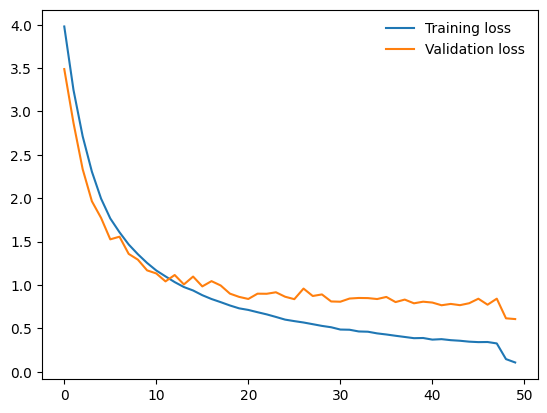

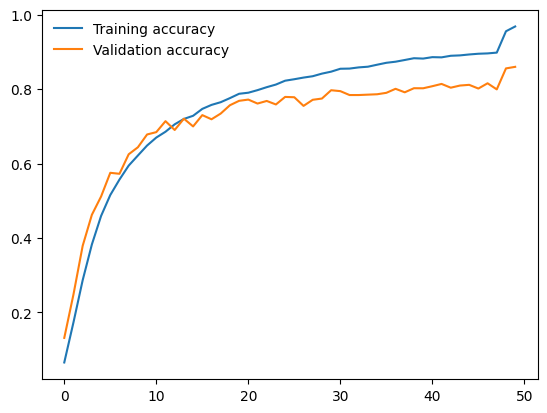

In [8]:
#train the model
train_losses, train_acc, val_losses, val_acc = train(model, train_loader, val_loader, criterion, optimizer, scheduler, hyper_params = prms, verbose = 2, test_transform = train_transform, experiment=prms["experiment"])

#plot the training and validation metrics
plot_metrics(train_losses, train_acc, val_losses, val_acc)

In [9]:
#test the model
test(model, test_loader, criterion, hyper_params = prms, experiment = prms["experiment"])

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/leothesouthafrican/mbnv3-vgg-100/6a518f69e0e84898a98afac7c470314f
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     inference_time  : 0.003710281229611354
COMET INFO:     test_accuracy   : 0.8534196019172668
COMET INFO:     test_loss       : 0.623269838573918
COMET INFO:     total_params    : 1620356
COMET INFO:     train_acc [50]  : (0.06510209292173386, 0.9685980677604675)
COMET INFO:     train_loss [50] : (0.10743319662509075, 3.9798773768767326)
COMET INFO:     val_acc [50]    : (0.13120195269584656, 0.8600628972053528)
COMET INFO:     val_loss [50]   : (0.6077703193874163, 3.4890455989717686)
COMET INFO:   Parameter

Test loss: 0.623.. 
Test accuracy: 0.853
Test Time: 0.0m 21s 211ms


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Please wait for metadata to finish uploading (timeout is 3600 seconds)
COMET INFO: Uploading 1 metrics, params and output messages


(0.623269838573918, tensor(0.8534, device='mps:0'))